In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# librairies classiques 
import numpy as np
import pandas as pd
import os 
import pathlib
import time
from tqdm.notebook import tqdm
from io import BytesIO

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [ ]:
pip install xlrd==1.2.0

     |████████████████████████████████| 103 kB 6.1 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [ ]:


# load train and test data sur google colab
path = '/content/drive/MyDrive/Eats up data/BDD'
files = os.listdir(path) # Returns list of files in the folder which is specifed path

for file in files:
    if file.endswith(".csv"):# Checking wheter file endswith .csv
        # os.sep returns the separtor of operator system
        exec(f"{file[:-4]} = pd.read_csv('{path}'+'{os.sep}'+'{file}')")
    elif file.endswith(".xls"):
        exec(f"{file[:-4]} = pd.read_excel('{path}'+'{os.sep}'+'{file}', usecols=[0,1,2,3,4,5,6,7])")

### On limite les courses qui remontent à 2010 pour éviter d'avoir trop de différence entre les pilotes et on va jusqu'à la date du challenge pour créer notre jeu d'entrainement

In [ ]:
races_train = races[(races.date >= '2010-01-01') & (races.date <= '2022-01-01')].reset_index()
races_test = races[(races.date > '2022-01-01')].reset_index()

In [ ]:
driver_standings.drop(['driverStandingsId','points','positionText','position','wins'], axis=1,inplace=True)
driver_standings.head()

,raceId,driverId
0,18,1
1,18,2
2,18,3
3,18,4
4,18,5


In [ ]:
drivers.drop(['driverRef','code','number','url'], axis=1,inplace=True)
drivers.rename(columns = {'nationality':'driver_nationality'}, inplace = True)
drivers.head()

,driverId,forename,surname,dob,driver_nationality
0,1,Lewis,Hamilton,1985-01-07,British
1,2,Nick,Heidfeld,1977-05-10,German
2,3,Nico,Rosberg,1985-06-27,German
3,4,Fernando,Alonso,1981-07-29,Spanish
4,5,Heikki,Kovalainen,1981-10-19,Finnish


In [ ]:
races_train_bis = races_train.drop(['url','index'], axis=1)
races_train_bis.rename(columns = {'name':'race_name'}, inplace = True)

races_test_bis = races_test.drop(['url','index'], axis=1)
races_test_bis.rename(columns = {'name':'race_name'}, inplace = True)

races_train_bis.head()

,raceId,year,round,circuitId,race_name,date,time
0,337,2010,1,3,Bahrain Grand Prix,2010-03-14,12:00:00
1,338,2010,2,1,Australian Grand Prix,2010-03-28,06:00:00
2,339,2010,3,2,Malaysian Grand Prix,2010-04-04,08:00:00
3,340,2010,4,17,Chinese Grand Prix,2010-04-18,06:00:00
4,341,2010,5,4,Spanish Grand Prix,2010-05-09,12:00:00


In [ ]:
circuits.drop(['name','location','circuitRef','lat','lng','url'], axis=1,inplace=True)
circuits.head()

,circuitId,country,alt
0,1,Australia,10
1,2,Malaysia,18
2,3,Bahrain,7
3,4,Spain,109
4,5,Turkey,130


In [ ]:
constructor_standings.drop(['constructorStandingsId','points','position','positionText','wins'], axis=1,inplace=True)
constructor_standings

,raceId,constructorId
0,18,1
1,18,2
2,18,3
3,18,4
4,18,5
...,...,...
12716,71,18
12717,72,18
12718,73,18
12719,74,18


In [ ]:
constructors.drop(['constructorRef','url'], axis=1,inplace=True)
constructors.rename(columns = {'nationality':'constructor_nationality', 'name': 'constructor_name'}, inplace = True)
constructors.head()

,constructorId,constructor_name,constructor_nationality
0,1,McLaren,British
1,2,BMW Sauber,German
2,3,Williams,British
3,4,Renault,French
4,5,Toro Rosso,Italian


### Ici il faut enlever la variable laps qui correspond au nombre de tour effectivement réalisé par le pilote. Nous récupérerons le  nb de laps sur la page wikipedia directemeny.

In [ ]:
results.drop(['number','grid','position','positionText','time','milliseconds','fastestLap','fastestLapTime','fastestLapSpeed','statusId','rank','points','laps'], axis=1,inplace=True)
results.head()

,resultId,raceId,driverId,constructorId,positionOrder
0,1,18,1,1,1
1,2,18,2,2,2
2,3,18,3,3,3
3,4,18,4,4,4
4,5,18,5,1,5


## Create train set

In [ ]:
temp1 = pd.merge(results, constructor_standings,how='left',on=['raceId','constructorId'])
temp2 = pd.merge(temp1, driver_standings, how='left', on=['raceId','driverId'])
temp3 = pd.merge(temp2, constructors, how='left', on='constructorId')
temp4 = pd.merge(temp3, drivers, how='left', on='driverId')
temp5 = pd.merge(temp4, races_train_bis, how='right', on=['raceId'])
temp6 = pd.merge(temp4, races_test_bis, how='right', on=['raceId'])
formule1_train = pd.merge(temp5, circuits, how='left', on=['circuitId'])
formule1_test = pd.merge(temp6, circuits, how='left', on=['circuitId'])
#formule1_test = formule1_test[:20]

In [ ]:
formule1_train.drop(['resultId','raceId','driverId','constructorId',], axis=1,inplace=True)

In [ ]:
def wins(position):
    if position == 1:
      return 1
    else:
      return 0

In [ ]:
formule1_train['win'] = formule1_train['positionOrder'].apply(wins)

In [ ]:
formule1_train.win.unique()

array([1, 0])

In [ ]:
formule1_train

,positionOrder,constructor_name,constructor_nationality,forename,surname,dob,driver_nationality,year,round,circuitId,race_name,date,time,country,alt,win
0,1,Ferrari,Italian,Fernando,Alonso,1981-07-29,Spanish,2010,1,3,Bahrain Grand Prix,2010-03-14,12:00:00,Bahrain,7,1
1,2,Ferrari,Italian,Felipe,Massa,1981-04-25,Brazilian,2010,1,3,Bahrain Grand Prix,2010-03-14,12:00:00,Bahrain,7,0
2,3,McLaren,British,Lewis,Hamilton,1985-01-07,British,2010,1,3,Bahrain Grand Prix,2010-03-14,12:00:00,Bahrain,7,0
3,4,Red Bull,Austrian,Sebastian,Vettel,1987-07-03,German,2010,1,3,Bahrain Grand Prix,2010-03-14,12:00:00,Bahrain,7,0
4,5,Mercedes,German,Nico,Rosberg,1985-06-27,German,2010,1,3,Bahrain Grand Prix,2010-03-14,12:00:00,Bahrain,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5072,16,Williams,British,Nicholas,Latifi,1995-06-29,Canadian,2021,22,24,Abu Dhabi Grand Prix,2021-12-12,13:00:00,UAE,3,0
5073,17,Alfa Romeo,Swiss,Antonio,Giovinazzi,1993-12-14,Italian,2021,22,24,Abu Dhabi Grand Prix,2021-12-12,13:00:00,UAE,3,0
5074,18,Williams,British,George,Russell,1998-02-15,British,2021,22,24,Abu Dhabi Grand Prix,2021-12-12,13:00:00,UAE,3,0
5075,19,Alfa Romeo,Swiss,Kimi,Räikkönen,1979-10-17,Finnish,2021,22,24,Abu Dhabi Grand Prix,2021-12-12,13:00:00,UAE,3,0


## Create test set

Pour créer le jeu de données de test on récupère d'abord les pilotes participant a la F1 en 2022:

In [ ]:
part1 = formule1_test.iloc[:-1,np.r_[5:11]][:20]
print(part1.shape)
part1.head()

(20, 6)


,constructor_name,constructor_nationality,forename,surname,dob,driver_nationality
0,Ferrari,Italian,Charles,Leclerc,1997-10-16,Monegasque
1,Ferrari,Italian,Carlos,Sainz,1994-09-01,Spanish
2,Mercedes,German,Lewis,Hamilton,1985-01-07,British
3,Mercedes,German,George,Russell,1998-02-15,British
4,Haas F1 Team,American,Kevin,Magnussen,1992-10-05,Danish


on a 20 pilotes en 2022

In [ ]:
part2 = formule1_test.iloc[:,11:].drop_duplicates()
print(part2.shape)
part2.head()

(22, 8)


,year,round,circuitId,race_name,date,time,country,alt
0,2022,1,3,Bahrain Grand Prix,2022-03-20,15:00:00,Bahrain,7
20,2022,2,77,Saudi Arabian Grand Prix,2022-03-27,17:00:00,Saudi Arabia,15
21,2022,3,1,Australian Grand Prix,2022-04-10,05:00:00,Australia,10
22,2022,4,21,Emilia Romagna Grand Prix,2022-04-24,13:00:00,Italy,37
23,2022,5,79,Miami Grand Prix,2022-05-08,19:30:00,United States,\N


il reste 22 circuits en 2022

In [ ]:
# Now to perform cross join, we will create
# a key column in both the DataFrames to
# merge on that key.
part1['key'] = 1
part2['key'] = 1
  
# to obtain the cross join we will merge on 
# the key and drop it.
formule1_test = pd.merge(part1, part2, on ='key').drop("key", 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if __name__ == '__main__':


In [ ]:
print(formule1_test.shape)

(440, 14)


On a bien un jeu de donnée test à 400 lignes

In [ ]:
#formule1_train.to_csv('/content/drive/MyDrive/Eats up data/BDD/train_f1.csv', index=False)
#formule1_test.to_csv('/content/drive/MyDrive/Eats up data/BDD/test_f1.csv', index=False)

## Création de nouvelles features dérivées de celles d'origines:

### L'âge du pilote au momement de la course

In [ ]:
formule1_train['dob'] = pd.to_datetime(formule1_train['dob'])
formule1_test['dob'] = pd.to_datetime(formule1_test['dob'])

In [ ]:
from datetime import date
 
def actual_age(birthdate):
    today = date.today()
    age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
    return age

def course_age(date_course, birthdate):
    date_course = date_course
    age = date_course.year - birthdate.year - ((date_course.month, date_course.day) < (birthdate.month, birthdate.day))
    return age

In [ ]:
formule1_train['actual_age'] = formule1_train['dob'].apply(actual_age)
formule1_train["course_age"] = formule1_train[["date", "dob"]].apply(lambda x : course_age(*x), axis=1)

formule1_test['actual_age'] = formule1_test['dob'].apply(actual_age)
formule1_test["course_age"] = formule1_test[["date", "dob"]].apply(lambda x : course_age(*x), axis=1)

### Créer la saison en fonction du mois de la course

In [ ]:
#formule1_train['date'].dt.month

#season_list = []
#hemisphere = 'Southern'
#for month in df['Month']:
#    season = find_season(month, hemisphere)
#    season_list.append(season)
    
#df['Season'] = season_list

### Créer un indicateur sur Matin, Midi, Soir

In [ ]:
formule1_train['time'] = pd.to_datetime(formule1_train['time'].astype(str)).dt.hour

formule1_test['time'] = pd.to_datetime(formule1_test['time'].astype(str)).dt.hour

In [ ]:
formule1_train['time'].value_counts()

12    1856
13    1038
6      428
19     270
5      226
16     198
18     190
7      154
15     144
11     125
17     124
8      116
14     100
9       70
10      20
20      18
Name: time, dtype: int64

In [ ]:
b = [0,6,12,14,20,24]
l = ['Night','Morning','Noon','Afternoon','Evening']
formule1_train['session'] = pd.cut(formule1_train['time'], bins=b, labels=l, include_lowest=True)
formule1_test['session'] = pd.cut(formule1_test['time'], bins=b, labels=l, include_lowest=True)

In [ ]:
formule1_train['session'] 

0       Morning
1       Morning
2       Morning
3       Morning
4       Morning
         ...   
5072       Noon
5073       Noon
5074       Noon
5075       Noon
5076       Noon
Name: session, Length: 5077, dtype: category
Categories (5, object): ['Night' < 'Morning' < 'Noon' < 'Afternoon' < 'Evening']

In [ ]:
formule1_train.drop(['dob','circuitId','date','time'], axis=1,inplace=True)
formule1_test.drop(['dob','circuitId','date','time'], axis=1,inplace=True)
formule1_train

,positionOrder,constructor_name,constructor_nationality,forename,surname,driver_nationality,year,round,race_name,country,alt,win,actual_age,course_age,session
0,1,Ferrari,Italian,Fernando,Alonso,Spanish,2010,1,Bahrain Grand Prix,Bahrain,7,1,40,28,Morning
1,2,Ferrari,Italian,Felipe,Massa,Brazilian,2010,1,Bahrain Grand Prix,Bahrain,7,0,40,28,Morning
2,3,McLaren,British,Lewis,Hamilton,British,2010,1,Bahrain Grand Prix,Bahrain,7,0,37,25,Morning
3,4,Red Bull,Austrian,Sebastian,Vettel,German,2010,1,Bahrain Grand Prix,Bahrain,7,0,34,22,Morning
4,5,Mercedes,German,Nico,Rosberg,German,2010,1,Bahrain Grand Prix,Bahrain,7,0,36,24,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5072,16,Williams,British,Nicholas,Latifi,Canadian,2021,22,Abu Dhabi Grand Prix,UAE,3,0,26,26,Noon
5073,17,Alfa Romeo,Swiss,Antonio,Giovinazzi,Italian,2021,22,Abu Dhabi Grand Prix,UAE,3,0,28,27,Noon
5074,18,Williams,British,George,Russell,British,2021,22,Abu Dhabi Grand Prix,UAE,3,0,24,23,Noon
5075,19,Alfa Romeo,Swiss,Kimi,Räikkönen,Finnish,2021,22,Abu Dhabi Grand Prix,UAE,3,0,42,42,Noon


In [ ]:
formule1_test

,constructor_name,constructor_nationality,forename,surname,driver_nationality,year,round,race_name,country,alt,actual_age,course_age,session
0,Ferrari,Italian,Charles,Leclerc,Monegasque,2022,1,Bahrain Grand Prix,Bahrain,7,24,24,Afternoon
1,Ferrari,Italian,Charles,Leclerc,Monegasque,2022,2,Saudi Arabian Grand Prix,Saudi Arabia,15,24,24,Afternoon
2,Ferrari,Italian,Charles,Leclerc,Monegasque,2022,3,Australian Grand Prix,Australia,10,24,24,Night
3,Ferrari,Italian,Charles,Leclerc,Monegasque,2022,4,Emilia Romagna Grand Prix,Italy,37,24,24,Noon
4,Ferrari,Italian,Charles,Leclerc,Monegasque,2022,5,Miami Grand Prix,United States,\N,24,24,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,AlphaTauri,Italian,Pierre,Gasly,French,2022,18,Japanese Grand Prix,Japan,45,26,26,Night
436,AlphaTauri,Italian,Pierre,Gasly,French,2022,19,United States Grand Prix,USA,161,26,26,Afternoon
437,AlphaTauri,Italian,Pierre,Gasly,French,2022,20,Mexico City Grand Prix,Mexico,2227,26,26,Afternoon
438,AlphaTauri,Italian,Pierre,Gasly,French,2022,21,Brazilian Grand Prix,Brazil,785,26,26,Afternoon


### Scrapping Météo

In [ ]:
import requests
import re
from bs4 import BeautifulSoup
from pandas.io.html import read_html
from datetime import date, datetime

In [ ]:
#races = races[(races.date >= '2010-01-01') & (races.date <= '2022-04-01')].reset_index()
races.head()

,raceId,year,round,circuitId,name,date,time,url
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...


In [ ]:

def extract_weather(dataset):
  weather_df = []
  with tqdm(total=len(dataset)) as pbar:
    for page, i in zip(dataset.url,range(len(dataset))):
        time.sleep(0.01)
        r = requests.get(page)
        website = r.text.encode('ascii', 'ignore')
        infoboxes = read_html(website, index_col=0)
        if len(infoboxes)==9 and len(infoboxes[0])==1:
          DF = infoboxes[1]
          DF = pd.DataFrame(DF.iloc[:,0])
          row = {}
          try:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]
            Weather  = DF[DF.index == 'Weather'].T
            row['Weather'] = ((Weather['Weather']).to_string(index=False))
            weather_df.append(pd.Series(row))
          except:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]        
            row['Weather'] = 'Pas de données météo'
            weather_df.append(pd.Series(row))
        elif len(infoboxes)==9 and len(infoboxes[0])>1:
          DF = infoboxes[0]
          DF = pd.DataFrame(DF.iloc[:,0])
          row = {}
          try:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]        
            Weather  = DF[DF.index == 'Weather'].T
            row['Weather'] = ((Weather['Weather']).to_string(index=False))
            weather_df.append(pd.Series(row))
          except:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]
            row['Weather'] = 'Pas de données météo'
            weather_df.append(pd.Series(row))
        if len(infoboxes)==10 and len(infoboxes[0])==1:
          DF = infoboxes[1]
          DF = pd.DataFrame(DF.iloc[:,0])
          row = {}
          try:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]
            Weather  = DF[DF.index == 'Weather'].T
            row['Weather'] = ((Weather['Weather']).to_string(index=False))
            weather_df.append(pd.Series(row))
          except:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]        
            row['Weather'] = 'Pas de données météo'
            weather_df.append(pd.Series(row))
        elif len(infoboxes)==10 and len(infoboxes[0])>1:
          DF = infoboxes[0]
          DF = pd.DataFrame(DF.iloc[:,0])
          row = {}
          try:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]
            Weather  = DF[DF.index == 'Weather'].T
            row['Weather'] = ((Weather['Weather']).to_string(index=False))
            weather_df.append(pd.Series(row))
          except:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]        
            row['Weather'] = 'Pas de données météo'
            weather_df.append(pd.Series(row))
        elif len(infoboxes) > 10 and len(infoboxes[0])==1:
          DF = infoboxes[1]
          DF = pd.DataFrame(DF.iloc[:,0])
          row = {}
          try:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]        
            Weather  = DF[DF.index == 'Weather'].T
            row['Weather'] = ((Weather['Weather']).to_string(index=False))
            weather_df.append(pd.Series(row))
          except:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]        
            row['Weather'] = 'Pas de données météo'
            weather_df.append(pd.Series(row))
        elif len(infoboxes) > 10 and len(infoboxes[0])>1:
          DF = infoboxes[0]
          DF = pd.DataFrame(DF.iloc[:,0])
          row = {}
          try:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]        
            Weather  = DF[DF.index == 'Weather'].T
            row['Weather'] = ((Weather['Weather']).to_string(index=False))
            weather_df.append(pd.Series(row))
          except:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]        
            row['Weather'] = 'Pas de données météo'
            weather_df.append(pd.Series(row))
        pbar.update(1)
    return pd.DataFrame(weather_df)


In [ ]:
def extract_type_course(dataset,type_dataset):

  course_df = []
  with tqdm(total=len(dataset)) as pbar:
    for page, i in (zip(dataset.url,range(0,len(dataset)))):
        time.sleep(0.01)
        r = requests.get(page)
        website = r.text.encode('ascii', 'ignore')
        infoboxes = read_html(website, index_col=0)
        if len(infoboxes)==9 and len(infoboxes[0])==1:
          DF = infoboxes[1]
          DF = pd.DataFrame(DF.iloc[:,0])
          row = {}
          try:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]            
            Course = DF[DF.index == 'Course'].T
            row['Course_Type'] = ((Course['Course']).to_string(index=False))
            course_df.append(pd.Series(row))
          except:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]            
            row['Course_Type'] = 'Pas de données sur le type de course'
            course_df.append(pd.Series(row))
        elif len(infoboxes)==9 and len(infoboxes[0])>1:
          DF = infoboxes[0]
          DF = pd.DataFrame(DF.iloc[:,0])
          row = {}
          try:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]            
            Course = DF[DF.index == 'Course'].T
            row['Course_Type'] = ((Course['Course']).to_string(index=False))
            course_df.append(pd.Series(row))
          except:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]            
            row['Course_Type'] = 'Pas de données sur le type de course'
            course_df.append(pd.Series(row))
        if len(infoboxes)==10 and len(infoboxes[0])==1:
          DF = infoboxes[1]
          DF = pd.DataFrame(DF.iloc[:,0])
          row = {}
          try:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]            
            Course = DF[DF.index == 'Course'].T
            row['Course_Type'] = ((Course['Course']).to_string(index=False))
            course_df.append(pd.Series(row))
          except:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]         
            row['Course_Type'] = 'Pas de données sur le type de course'
            course_df.append(pd.Series(row))
        elif len(infoboxes)==10 and len(infoboxes[0])>1:
          DF = infoboxes[0]
          DF = pd.DataFrame(DF.iloc[:,0])
          row = {}
          try:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]         
            Course = DF[DF.index == 'Course'].T
            row['Course_Type'] = ((Course['Course']).to_string(index=False))
            course_df.append(pd.Series(row))
          except:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]         
            row['Course_Type'] = 'Pas de données sur le type de course'
            course_df.append(pd.Series(row))
        elif len(infoboxes) > 10 and len(infoboxes[0])==1:
          DF = infoboxes[1]
          DF = pd.DataFrame(DF.iloc[:,0])
          row = {}
          try:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]         
            Course = DF[DF.index == 'Course'].T
            row['Course_Type'] = ((Course['Course']).to_string(index=False))
            course_df.append(pd.Series(row))
          except:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]         
            row['Course_Type'] = 'Pas de données sur le type de course'
            course_df.append(pd.Series(row))
        elif len(infoboxes) > 10 and len(infoboxes[0])>1:
          DF = infoboxes[0]
          DF = pd.DataFrame(DF.iloc[:,0])
          row = {}
          try:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]         
            Course = DF[DF.index == 'Course'].T
            row['Course_Type'] = ((Course['Course']).to_string(index=False))
            course_df.append(pd.Series(row))
          except:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]         
            row['Course_Type'] = 'Pas de données sur le type de course'
            course_df.append(pd.Series(row))
        elif type_dataset=='test':
          DF = infoboxes[0]
          DF = pd.DataFrame(DF.iloc[:,0])
          row = {}
          try:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]         
            Course = DF[DF.index == 'Course'].T
            row['Course_Type'] = ((Course['Course']).to_string(index=False))
            course_df.append(pd.Series(row))
          except:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]         
            row['Course_Type'] = 'Pas de données sur le type de course'
            course_df.append(pd.Series(row))
        pbar.update(1)
    return course_df

In [ ]:
def extract_distance(dataset, type_dataset):
  distance_df = []

  with tqdm(total=len(dataset)) as pbar:
    if type_dataset == 'train':
      for page, i in zip(dataset.url,range(0,len(dataset))):
          time.sleep(0.01)
          r = requests.get(page)
          website = r.text.encode('ascii', 'ignore')
          infoboxes = read_html(website, index_col=0)
          if len(infoboxes)==9 and len(infoboxes[0])==1:
            DF = infoboxes[1]
            DF = pd.DataFrame(DF.iloc[:,0])
            row = {}
            try:
              row['year'] = dataset.year[i]
              row['race_name'] = dataset.name[i]         
              Distance = DF[DF.index == 'Distance'].T
              row['Distance'] = ((Distance['Distance']).to_string(index=False))
              distance_df.append(pd.Series(row))
            except:
              row['year'] = dataset.year[i]
              row['race_name'] = dataset.name[i]         
              row['Distance'] = '0'
              distance_df.append(pd.Series(row))
          elif len(infoboxes)==9 and len(infoboxes[0])>1:
            DF = infoboxes[0]
            DF = pd.DataFrame(DF.iloc[:,0])
            row = {}
            try:
              row['year'] = dataset.year[i]
              row['race_name'] = dataset.name[i]         
              Distance = DF[DF.index == 'Distance'].T
              row['Distance'] = ((Distance['Distance']).to_string(index=False))
              distance_df.append(pd.Series(row))
            except:
              row['year'] = dataset.year[i]
              row['race_name'] = dataset.name[i]         
              row['Distance'] = '0'
              distance_df.append(pd.Series(row))
          if len(infoboxes)==10 and len(infoboxes[0])==1:
            DF = infoboxes[1]
            DF = pd.DataFrame(DF.iloc[:,0])
            row = {}
            try:
              row['year'] = dataset.year[i]
              row['race_name'] = dataset.name[i]         
              Distance = DF[DF.index == 'Distance'].T
              row['Distance'] = ((Distance['Distance']).to_string(index=False))
              distance_df.append(pd.Series(row))
            except:
              row['year'] = dataset.year[i]
              row['race_name'] = dataset.name[i]         
              row['Distance'] = '0'
              distance_df.append(pd.Series(row))
          elif len(infoboxes)==10 and len(infoboxes[0])>1:
            DF = infoboxes[0]
            DF = pd.DataFrame(DF.iloc[:,0])
            row = {}
            try:
              row['year'] = dataset.year[i]
              row['race_name'] = dataset.name[i]         
              Distance = DF[DF.index == 'Distance'].T
              row['Distance'] = ((Distance['Distance']).to_string(index=False))
              distance_df.append(pd.Series(row))
            except:
              row['year'] = dataset.year[i]
              row['race_name'] = dataset.name[i]         
              row['Distance'] = '0'
              distance_df.append(pd.Series(row))
          elif len(infoboxes) > 10 and len(infoboxes[0])==1:
            DF = infoboxes[1]
            DF = pd.DataFrame(DF.iloc[:,0])
            row = {}
            try:
              row['year'] = dataset.year[i]
              row['race_name'] = dataset.name[i]         
              Distance = DF[DF.index == 'Distance'].T
              row['Distance'] = ((Distance['Distance']).to_string(index=False))
              distance_df.append(pd.Series(row))
            except:
              row['year'] = dataset.year[i]
              row['race_name'] = dataset.name[i]         
              row['Distance'] = '0'
              distance_df.append(pd.Series(row))
          elif len(infoboxes) > 10 and len(infoboxes[0])>1:
            DF = infoboxes[0]
            DF = pd.DataFrame(DF.iloc[:,0])
            row = {}
            try:
              row['year'] = dataset.year[i]
              row['race_name'] = dataset.name[i]         
              Distance = DF[DF.index == 'Distance'].T
              row['Distance'] = ((Distance['Distance']).to_string(index=False))
              distance_df.append(pd.Series(row))
            except:
              row['year'] = dataset.year[i]
              row['race_name'] = dataset.name[i]         
              row['Distance'] = '0'
              distance_df.append(pd.Series(row))
          pbar.update(1)
    elif type_dataset=="test":
      pages = []
      for r in formule1_test.country.str.split('Grand Prix')[:22]: 
        pages.append('https://www.formula1.com/en/racing/2022/'+ str(r[0]).replace(" ", "").replace(" ","_").replace("UK", "Great_Britain").replace("UK", "Great_Britain").replace('UAE','United_Arab_Emirates').replace('USA','United_States').replace('UnitedStates','Miami').replace('SaudiArabia','Saudi_Arabia') + '/Circuit.html')
        country = pages[:22]
      for page, i in zip(country,range(0,len(dataset))):
          time.sleep(0.01)
          r = requests.get(page)
          soup = BeautifulSoup(r.content)
          row = {}
          try:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i] 
            row['laps'] = soup.find_all('p', {'class': "f1-bold--stat"})[1].next.replace(' ','',1)
            row['Distance'] = soup.find_all('p', {'class': "f1-bold--stat"})[3].next.replace(' ','',1)
            distance_df.append(pd.Series(row))
          except:
            row['year'] = dataset.year[i]
            row['race_name'] = dataset.name[i]         
            row['Distance'] = '0'
            distance_df.append(pd.Series(row))
      pbar.update(1)
    return distance_df

In [ ]:
weather_df_train = extract_weather(races_train)

course_df_train = extract_type_course(races_train, 'train')
course_df_test = extract_type_course(races_test, 'test')

distance_df_train = extract_distance(races_train, 'train')
distance_df_test = extract_distance(races_test, 'test')

  0%|          | 0/237 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

In [ ]:
W = pd.DataFrame(weather_df_train)

C_train = pd.DataFrame(course_df_train)
C_test = pd.DataFrame(course_df_test)

D_train = pd.DataFrame(distance_df_train)
D_test = pd.DataFrame(distance_df_test)

In [ ]:
W

,year,race_name,Weather
0,2010,Bahrain Grand Prix,Sunny
1,2010,Australian Grand Prix,Overcast with light rain at start
2,2010,Malaysian Grand Prix,"Mainly cloudy, dry"
3,2010,Chinese Grand Prix,"Cloudy, rain"
4,2010,Spanish Grand Prix,"Mainly cloudy, dry"
...,...,...,...
231,2021,United States Grand Prix,Sunny
232,2021,Mexico City Grand Prix,Sunny
233,2021,São Paulo Grand Prix,Pas de données météo
234,2021,Saudi Arabian Grand Prix,Clear


In [ ]:
W.Weather.iloc[1:30]

1                     Overcast with light rain at start
2                                    Mainly cloudy, dry
3                                          Cloudy, rain
4                                    Mainly cloudy, dry
5                                    Mainly cloudy, dry
6     Air: 28 to 29 C (82 to 84 F) Track: 39 to 49 C...
7     Warm with temperatures approaching 26 C (79 F)...
8                                                Dry[3]
9                                          Mainly sunny
10                                Mainly cloudy, dry[4]
11                           Mainly sunny28 C (82 F)[1]
12                                    Intermittent rain
13                                                Sunny
14    Clear; Air temp 29 to 30 C (84 to 86 F), Track...
15                                                Sunny
16             Rain; Air 20 C (68 F), Track 18 C (64 F)
17                                   Clear; 25 C (77 F)
18    Dry[3] Air Temp 28 C (82 F)[3] Track Temp 

## Correction de quelques erreurs de scrapping

In [ ]:
W[(W.Weather.str.contains('Pas de données météo'))]

,year,race_name,Weather
60,2013,Chinese Grand Prix,Pas de données météo
61,2013,Bahrain Grand Prix,Pas de données météo
68,2013,Belgian Grand Prix,Pas de données météo
137,2017,Bahrain Grand Prix,Pas de données météo
138,2017,Russian Grand Prix,Pas de données météo
139,2017,Spanish Grand Prix,Pas de données météo
140,2017,Monaco Grand Prix,Pas de données météo
153,2017,Brazilian Grand Prix,Pas de données météo
156,2018,Bahrain Grand Prix,Pas de données météo
157,2018,Chinese Grand Prix,Pas de données météo


In [ ]:
W.iloc[187, W.columns.get_loc('Weather')] = 'Sunny'
W.iloc[233, W.columns.get_loc('Weather')] = 'Sunny'

In [ ]:
C_train[(C_train.Course_Type.str.contains('Pas de données sur le type de course'))]

,year,race_name,Course_Type
187,2019,Hungarian Grand Prix,Pas de données sur le type de course
233,2021,São Paulo Grand Prix,Pas de données sur le type de course


In [ ]:
C_train.iloc[187, C_train.columns.get_loc('Course_Type')] = 'Permanent racing facility'
C_train.iloc[233, C_train.columns.get_loc('Course_Type')] = 'Permanent racing facility'

In [ ]:
D_train[(D_train.Distance.str.contains('Pas de données sur la distance'))]

,year,race_name,Distance


In [ ]:
D_train.iloc[187, D_train.columns.get_loc('Distance')] = '70 laps, 306.630 km (190.531 mi)'
D_train.iloc[233, D_train.columns.get_loc('Distance')] = '71 laps, 305.879 km (190.064 mi)'

D_test.iloc[3, D_test.columns.get_loc('laps')] = 63
D_test.iloc[3, D_test.columns.get_loc('Distance')] = 309.049

In [ ]:
no_weather = W[(W.Weather.str.contains('Pas de données météo'))]
print(len(no_weather))

25


## Pour C_test on récupère directement l'info sur les données train puisque ce sont les mêmes circuits

In [ ]:
C_train_bis = C_train[['year','Course_Type','race_name']]
C_train_bis = C_train_bis[(C_train_bis.year == 2019) | (C_train_bis.year == 2021)] 
C_train_bis = C_train_bis.drop_duplicates()

In [ ]:
C_test = C_test.merge(C_train_bis, on=['race_name'], how='left', suffixes=['', '_'])

In [ ]:
C_test = C_test[['year','race_name','Course_Type','Course_Type_']].drop_duplicates()
C_test.head()

,year,race_name,Course_Type,Course_Type_
0,2022,Bahrain Grand Prix,Permanent racing facility,Permanent racing facility
4,2022,Saudi Arabian Grand Prix,Street circuit,Street Circuit
6,2022,Australian Grand Prix,Temporary street circuit,Temporary street circuit
8,2022,Emilia Romagna Grand Prix,Pas de données sur le type de course,Permanent racing facility
9,2022,Miami Grand Prix,Street Circuit,NaN


In [ ]:
C_test.iloc[12, C_test.columns.get_loc('Course_Type_')] = 'Permanent racing facility'
C_test.iloc[17, C_test.columns.get_loc('Course_Type_')] = 'Permanent racing facility'
C_test.iloc[1, C_test.columns.get_loc('Course_Type_')] = 'Permanent racing facility'
C_test.iloc[5, C_test.columns.get_loc('Course_Type_')] = 'Street Circuit'

In [ ]:
C_test = C_test[['year','race_name','Course_Type_']]
C_test.rename(columns = {'Course_Type_':'Course_Type'}, inplace = True)
C_test

,year,race_name,Course_Type
0,2022,Bahrain Grand Prix,Permanent racing facility
4,2022,Saudi Arabian Grand Prix,Permanent racing facility
6,2022,Australian Grand Prix,Temporary street circuit
8,2022,Emilia Romagna Grand Prix,Permanent racing facility
9,2022,Miami Grand Prix,NaN
10,2022,Spanish Grand Prix,Street Circuit
12,2022,Monaco Grand Prix,Street circuit
14,2022,Azerbaijan Grand Prix,Temporary street circuit
15,2022,Azerbaijan Grand Prix,Street circuit
16,2022,Canadian Grand Prix,Street circuit


## Création d'un indicateur numérique de la météo : 0 -> Pas de météo, 1 -> Météo clémente, 2 -> Météo neutre , 3 -> Météo peu clémente

In [ ]:
wword = 'rain|rainy|cloud|cloudy|overcast|sun|sunny|haze|hazy|wind|dry|warm|clear|fine|hot|cold|humid|mild|wet|showers|28C|29C|30C|31C|32C|33C|34C|35C|36C|37C|38C|39C|40C' #weather words
iword = 'light|very|Partly|mainly|mostly|heavy|Intermittent|Slightly' #intensity words

def weather_finder(x):
    return re.findall(wword, x, flags=re.IGNORECASE)

def intensity_finder(x):
    return re.findall(iword, x, flags=re.IGNORECASE)

In [ ]:
#W['Intensity']= W["Weather"].apply(intensity_finder)
W['Weather']= W["Weather"].apply(weather_finder)

In [ ]:
W.head()

,year,race_name,Weather
0,2010,Bahrain Grand Prix,[Sun]
1,2010,Australian Grand Prix,"[Overcast, rain]"
2,2010,Malaysian Grand Prix,"[cloud, dry]"
3,2010,Chinese Grand Prix,"[Cloud, rain]"
4,2010,Spanish Grand Prix,"[cloud, dry]"


In [ ]:
W['Weather'] = [','.join(map(str, l)) for l in W['Weather']]
#W['Intensity'] = [','.join(map(str, l)) for l in W['Intensity']] 

In [ ]:
W.iloc[6, W.columns.get_loc('Weather')] = 'Warm'
W.iloc[161, W.columns.get_loc('Weather')] = 'wind'
W.iloc[182, W.columns.get_loc('Weather')] = 'Warm, wind'

In [ ]:
max(W.Weather.str.count(','))

3

In [ ]:
W[['Weather','Weather2','Weather3','Weather4']] = W['Weather'].str.split(',', expand=True)
W.fillna("",inplace=True)
W.head()

,year,race_name,Weather,Weather2,Weather3,Weather4
0,2010,Bahrain Grand Prix,Sun,,,
1,2010,Australian Grand Prix,Overcast,rain,,
2,2010,Malaysian Grand Prix,cloud,dry,,
3,2010,Chinese Grand Prix,Cloud,rain,,
4,2010,Spanish Grand Prix,cloud,dry,,


In [ ]:
no_weather_bis = W[(W.Weather=='')] # Table à comparer avec la table no_weather 
print(len(no_weather_bis))
#no_weather_bis

25


Ici il s'agit de voir si on a bien récupéré toutes les météos

In [ ]:
diff = no_weather.merge(no_weather_bis, on='race_name', how='outer', suffixes=['', '_'], indicator=True)
#diff 

In [ ]:
W.Weather.unique()

array(['Sun', 'Overcast', 'cloud', 'Cloud', 'Warm', 'Dry', 'sun', 'rain',
       'Clear', 'Rain', 'Fine', 'Wet', 'Hot', '', 'Mild', 'hot', 'wind',
       'hazy', 'Wind'], dtype=object)

### Regroupement des modalités 

In [ ]:
def temp(x):
  if x.lower() in ('sun|sunny|clear|dry|fine|mild'):
    return int(1)
  elif x.lower() in ('cloud|cloudy|overcast|cold'):
    return int(2)
  elif x.lower() in ('wind|rain|wet|hazy|haze|showers|humid|warm|hot'):
    return int(3)
  elif x == None : 
    return int(0) 
  else: 
    return int(0)


In [ ]:
W['wtemp'] = W['Weather'].apply(temp)
W['wtemp2'] = W['Weather2'].apply(temp)
W['wtemp3'] = W['Weather3'].apply(temp)
W['wtemp4'] = W['Weather4'].apply(temp)

In [ ]:
weathers_ = ["wtemp","wtemp2","wtemp3","wtemp4"]
W["weather"] = W[weathers_].values.argmax(axis=1)

In [ ]:
conditions = [
    W['weather'] == 0, 
    W['weather'] == 1 , 
    W['weather'] == 2, 
    W['weather'] == 3
    ]

values = [W['wtemp'], W['wtemp2'], W['wtemp3'], W['wtemp4']]

W['weather'] = np.select(conditions, values)


Ici on créer l'inticateur WEATHER qui regroupe les modalités ensemble et prend le max. par exemple si pour un circuit on a Cloud & Rain, cloud est classé en catégorie 2 : Neutre et Rain en catégorie 3 : Hard on prendra donc Hard pour cette course

In [ ]:
W.drop(['Weather','Weather2','Weather3','Weather4','wtemp','wtemp2','wtemp3','wtemp4'], axis=1,inplace=True)
W

,year,race_name,weather
0,2010,Bahrain Grand Prix,1
1,2010,Australian Grand Prix,3
2,2010,Malaysian Grand Prix,2
3,2010,Chinese Grand Prix,3
4,2010,Spanish Grand Prix,2
...,...,...,...
231,2021,United States Grand Prix,1
232,2021,Mexico City Grand Prix,1
233,2021,São Paulo Grand Prix,1
234,2021,Saudi Arabian Grand Prix,1


In [ ]:
C_train['Course_Type'] = C_train['Course_Type'].str.split('[', expand=True)[0]


In [ ]:
D_train[['laps','Distance']] = D_train['Distance'].str.split('km', expand=True)[0].str.split('laps,',expand=True)
D_train['Distance'] = D_train.Distance.str.split('\xa0',expand=True)[0].str.strip()
D_train['laps'] = D_train.laps.str.split('lap',expand=True)[0].str.strip()
#D_train.drop(['Distance'], axis=1,inplace=True)


In [ ]:
D_train

,year,race_name,Distance,laps
0,2010,Bahrain Grand Prix,308.405,49
1,2010,Australian Grand Prix,307.574,58
2,2010,Malaysian Grand Prix,310.408,56
3,2010,Chinese Grand Prix,305.066,56
4,2010,Spanish Grand Prix,307.104,66
...,...,...,...,...
231,2021,United States Grand Prix,308.405,56
232,2021,Mexico City Grand Prix,305.354,71
233,2021,São Paulo Grand Prix,305.879,71
234,2021,Saudi Arabian Grand Prix,308.450,50


### Creation de la table des nouveaux KPI pour le TRAIN

In [ ]:
temp1 = pd.merge(W, C_train, how='outer',on=['year','race_name'])
weather_course_type_distance_train = pd.merge(temp1, D_train, how='outer', on=['year','race_name'])

In [ ]:
weather_course_type_distance_train.head()

,year,race_name,weather,Course_Type,Distance,laps
0,2010,Bahrain Grand Prix,1,Permanent racing facility,308.405,49
1,2010,Australian Grand Prix,3,Temporary street circuit,307.574,58
2,2010,Malaysian Grand Prix,2,Permanent racing facility,310.408,56
3,2010,Chinese Grand Prix,3,Permanent racing facility,305.066,56
4,2010,Spanish Grand Prix,2,Permanent racing facility,307.104,66


### Création de la table des nouveaux KPI pour le TEST

In [ ]:
course_type_distance_test = pd.merge(C_test, D_test, how='outer',on=['year','race_name'])
course_type_distance_test

,year,race_name,Course_Type,laps,Distance
0,2022,Bahrain Grand Prix,Permanent racing facility,57,308.238
1,2022,Saudi Arabian Grand Prix,Permanent racing facility,50,308.45
2,2022,Australian Grand Prix,Temporary street circuit,58,306.124
3,2022,Emilia Romagna Grand Prix,Permanent racing facility,63,309.049
4,2022,Miami Grand Prix,NaN,57,308.37
5,2022,Spanish Grand Prix,Street Circuit,66,308.424
6,2022,Monaco Grand Prix,Street circuit,78,260.286
7,2022,Azerbaijan Grand Prix,Temporary street circuit,51,306.049
8,2022,Azerbaijan Grand Prix,Street circuit,51,306.049
9,2022,Canadian Grand Prix,Street circuit,70,305.27


In [ ]:
#y = pd.get_dummies(weather_course_type_distance.Course_Type, prefix='course_type')

In [ ]:
#weather_course_type_distance = pd.merge(weather_course_type_distance, y, left_index=True, right_index=True)

In [ ]:
#weather_course_type_distance.drop(['Course_Type'], axis=1,inplace=True)
#weather_course_type_distance.head()

In [ ]:
print(weather_course_type_distance_train.shape)
print(formule1_train.shape)

(236, 6)
(5077, 15)


In [ ]:
#weather_course_type_distance_train.to_csv('/content/drive/MyDrive/Eats up data/BDD/weather_type_course_distance.csv', index=False)

### Merge des tables formule1_train et weather_course_type_distance_train:

In [ ]:
formule_one_train = pd.merge(formule1_train, weather_course_type_distance_train,how='left',on=['year','race_name'])

In [ ]:
features_keep = ['year','race_name','country','forename','surname','constructor_name','constructor_nationality','driver_nationality','round','alt','actual_age','course_age','session','weather','laps','Distance','Course_Type','positionOrder','win']
formule_one_train = formule_one_train[features_keep]

In [ ]:
add_nb_wins = pd.DataFrame(formule_one_train.groupby(['forename','surname','race_name']).sum()['win']).reset_index()
add_nb_wins.rename(columns = {'win':'number_wins_course'}, inplace = True)

In [ ]:
formule_one_train = formule_one_train.merge(add_nb_wins, how='left', on=['forename', 'surname','race_name'])
formule_one_train = formule_one_train.iloc[:-1,:]
formule_one_train.head()

,year,race_name,country,forename,surname,constructor_name,constructor_nationality,driver_nationality,round,alt,actual_age,course_age,session,weather,laps,Distance,Course_Type,positionOrder,win,number_wins_course
0,2010,Bahrain Grand Prix,Bahrain,Fernando,Alonso,Ferrari,Italian,Spanish,1,7,40,28,Morning,1.0,49,308.405,Permanent racing facility,1,1,1
1,2010,Bahrain Grand Prix,Bahrain,Felipe,Massa,Ferrari,Italian,Brazilian,1,7,40,28,Morning,1.0,49,308.405,Permanent racing facility,2,0,0
2,2010,Bahrain Grand Prix,Bahrain,Lewis,Hamilton,McLaren,British,British,1,7,37,25,Morning,1.0,49,308.405,Permanent racing facility,3,0,5
3,2010,Bahrain Grand Prix,Bahrain,Sebastian,Vettel,Red Bull,Austrian,German,1,7,34,22,Morning,1.0,49,308.405,Permanent racing facility,4,0,4
4,2010,Bahrain Grand Prix,Bahrain,Nico,Rosberg,Mercedes,German,German,1,7,36,24,Morning,1.0,49,308.405,Permanent racing facility,5,0,1


Hamilton gg 5 fois Bahrain

In [ ]:
formule_one_train['alt'] =  formule_one_train['alt'].replace('\\N','0')

### One Hot encoding

In [ ]:
country_one_hot = pd.get_dummies(formule_one_train.country, prefix='country')
constructor_nationality_one_hot = pd.get_dummies(formule_one_train.constructor_nationality, prefix='constructor_nationality')
constructor_name_one_hot = pd.get_dummies(formule_one_train.constructor_name, prefix='constructor_name')
driver_nationality_one_hot = pd.get_dummies(formule_one_train.driver_nationality, prefix='driver_nationality')
session_one_hot = pd.get_dummies(formule_one_train.session, prefix='driver_nationality')
Course_Type_one_hot = pd.get_dummies(formule_one_train.Course_Type, prefix='Course_Type')


In [ ]:
temp = pd.merge(country_one_hot, constructor_nationality_one_hot, left_index=True, right_index=True)
temp2 = pd.merge(temp, constructor_name_one_hot, left_index=True, right_index=True)
temp3 = pd.merge(temp2, driver_nationality_one_hot, left_index=True, right_index=True)
temp4 = pd.merge(temp3, session_one_hot, left_index=True, right_index=True)
formule_one_train_categ_var = pd.merge(temp4, Course_Type_one_hot, left_index=True, right_index=True)

In [ ]:
formule_one_train = pd.merge(formule_one_train, formule_one_train_categ_var, left_index=True, right_index=True)

In [ ]:
formule_one_train.drop(['country','constructor_name','constructor_nationality','driver_nationality','session','Course_Type'],axis=1,inplace=True)

In [ ]:
formule_one_train.head()

,year,race_name,forename,surname,round,alt,actual_age,course_age,weather,laps,...,driver_nationality_Evening,Course_Type_Korea International Circuit,Course_Type_Permanent Racing Facility,Course_Type_Permanent racing circuit,Course_Type_Permanent racing facility,Course_Type_Semi-permanent racing facility,Course_Type_Street Circuit,Course_Type_Street circuit,Course_Type_Temporary street circuit,Course_Type_Yas Marina Circuit
0,2010,Bahrain Grand Prix,Fernando,Alonso,1,7,40,28,1.0,49,...,0,0,0,0,1,0,0,0,0,0
1,2010,Bahrain Grand Prix,Felipe,Massa,1,7,40,28,1.0,49,...,0,0,0,0,1,0,0,0,0,0
2,2010,Bahrain Grand Prix,Lewis,Hamilton,1,7,37,25,1.0,49,...,0,0,0,0,1,0,0,0,0,0
3,2010,Bahrain Grand Prix,Sebastian,Vettel,1,7,34,22,1.0,49,...,0,0,0,0,1,0,0,0,0,0
4,2010,Bahrain Grand Prix,Nico,Rosberg,1,7,36,24,1.0,49,...,0,0,0,0,1,0,0,0,0,0


### Merge des tables formule1_test et course_type_distance_test:

In [ ]:
course_type_distance_test.drop(8,axis=0,inplace=True)

In [ ]:
formule_one_test = pd.merge(formule1_test, course_type_distance_test, how='left',on=['year','race_name'])
formule_one_test = formule_one_test.merge(add_nb_wins, how='left', on=['forename', 'surname','race_name'])
formule_one_test

,constructor_name,constructor_nationality,forename,surname,driver_nationality,year,round,race_name,country,alt,actual_age,course_age,session,Course_Type,laps,Distance,number_wins_course
0,Ferrari,Italian,Charles,Leclerc,Monegasque,2022,1,Bahrain Grand Prix,Bahrain,7,24,24,Afternoon,Permanent racing facility,57,308.238,0.0
1,Ferrari,Italian,Charles,Leclerc,Monegasque,2022,2,Saudi Arabian Grand Prix,Saudi Arabia,15,24,24,Afternoon,Permanent racing facility,50,308.45,0.0
2,Ferrari,Italian,Charles,Leclerc,Monegasque,2022,3,Australian Grand Prix,Australia,10,24,24,Night,Temporary street circuit,58,306.124,0.0
3,Ferrari,Italian,Charles,Leclerc,Monegasque,2022,4,Emilia Romagna Grand Prix,Italy,37,24,24,Noon,Permanent racing facility,63,309.049,0.0
4,Ferrari,Italian,Charles,Leclerc,Monegasque,2022,5,Miami Grand Prix,United States,\N,24,24,Afternoon,NaN,57,308.37,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,AlphaTauri,Italian,Pierre,Gasly,French,2022,18,Japanese Grand Prix,Japan,45,26,26,Night,Permanent racing facility,53,307.471,0.0
436,AlphaTauri,Italian,Pierre,Gasly,French,2022,19,United States Grand Prix,USA,161,26,26,Afternoon,Permanent racing facility,56,308.405,0.0
437,AlphaTauri,Italian,Pierre,Gasly,French,2022,20,Mexico City Grand Prix,Mexico,2227,26,26,Afternoon,Permanent racing facility,71,305.354,0.0
438,AlphaTauri,Italian,Pierre,Gasly,French,2022,21,Brazilian Grand Prix,Brazil,785,26,26,Afternoon,Permanent racing facility,71,305.879,0.0


### Ajout de la météo pour le test set

In [ ]:
part2_test = pd.DataFrame(formule_one_train.weather.unique())

In [ ]:
formule_one_test['key'] = 1
part2_test['key'] = 1
  
# to obtain the cross join we will merge on 
# the key and drop it.
formule_one_test = pd.merge(formule_one_test, part2_test, on ='key').drop("key", 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [ ]:
formule_one_test.rename(columns = {0:'weather'}, inplace = True)
formule_one_test['alt'] =  formule_one_test['alt'].replace('\\N','0')
formule_one_test

,constructor_name,constructor_nationality,forename,surname,driver_nationality,year,round,race_name,country,alt,actual_age,course_age,session,Course_Type,laps,Distance,number_wins_course,weather
0,Ferrari,Italian,Charles,Leclerc,Monegasque,2022,1,Bahrain Grand Prix,Bahrain,7,24,24,Afternoon,Permanent racing facility,57,308.238,0.0,1.0
1,Ferrari,Italian,Charles,Leclerc,Monegasque,2022,1,Bahrain Grand Prix,Bahrain,7,24,24,Afternoon,Permanent racing facility,57,308.238,0.0,3.0
2,Ferrari,Italian,Charles,Leclerc,Monegasque,2022,1,Bahrain Grand Prix,Bahrain,7,24,24,Afternoon,Permanent racing facility,57,308.238,0.0,2.0
3,Ferrari,Italian,Charles,Leclerc,Monegasque,2022,1,Bahrain Grand Prix,Bahrain,7,24,24,Afternoon,Permanent racing facility,57,308.238,0.0,NaN
4,Ferrari,Italian,Charles,Leclerc,Monegasque,2022,2,Saudi Arabian Grand Prix,Saudi Arabia,15,24,24,Afternoon,Permanent racing facility,50,308.45,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1755,AlphaTauri,Italian,Pierre,Gasly,French,2022,21,Brazilian Grand Prix,Brazil,785,26,26,Afternoon,Permanent racing facility,71,305.879,0.0,NaN
1756,AlphaTauri,Italian,Pierre,Gasly,French,2022,22,Abu Dhabi Grand Prix,UAE,3,26,26,Noon,Permanent racing facility,58,306.183,0.0,1.0
1757,AlphaTauri,Italian,Pierre,Gasly,French,2022,22,Abu Dhabi Grand Prix,UAE,3,26,26,Noon,Permanent racing facility,58,306.183,0.0,3.0
1758,AlphaTauri,Italian,Pierre,Gasly,French,2022,22,Abu Dhabi Grand Prix,UAE,3,26,26,Noon,Permanent racing facility,58,306.183,0.0,2.0


### One Hot Encoding

In [ ]:
country_one_hot = pd.get_dummies(formule_one_test.country, prefix='country')
constructor_nationality_one_hot = pd.get_dummies(formule_one_test.constructor_nationality, prefix='constructor_nationality')
constructor_name_one_hot = pd.get_dummies(formule_one_test.constructor_name, prefix='constructor_name')
driver_nationality_one_hot = pd.get_dummies(formule_one_test.driver_nationality, prefix='driver_nationality')
session_one_hot = pd.get_dummies(formule_one_test.session, prefix='driver_nationality')
Course_Type_one_hot = pd.get_dummies(formule_one_test.Course_Type, prefix='Course_Type')


In [ ]:
temp = pd.merge(country_one_hot, constructor_nationality_one_hot, left_index=True, right_index=True)
temp2 = pd.merge(temp, constructor_name_one_hot, left_index=True, right_index=True)
temp3 = pd.merge(temp2, driver_nationality_one_hot, left_index=True, right_index=True)
temp4 = pd.merge(temp3, session_one_hot, left_index=True, right_index=True)
formule_one_test_categ_var = pd.merge(temp4, Course_Type_one_hot, left_index=True, right_index=True)

In [ ]:
formule_one_test = pd.merge(formule_one_test, formule_one_test_categ_var, left_index=True, right_index=True)

In [ ]:
formule_one_test.drop(['country','constructor_name','constructor_nationality','driver_nationality','session','Course_Type'],axis=1,inplace=True)

### Check des variables avec des modalités différentes entre train et test

In [ ]:
cols_diff_train = formule_one_train.columns.difference(formule_one_test.columns)
formule_one_test[cols_diff_train[:-2]] = 0


In [ ]:
cols_diff_test = formule_one_test.columns.difference(formule_one_train.columns)
formule_one_train[cols_diff_test] = 0

In [ ]:
formule_one_train = formule_one_train.dropna()
formule_one_test = formule_one_test.dropna()

formule_one_train.reset_index(drop=True)
formule_one_test.reset_index(drop=True)

,forename,surname,year,round,race_name,alt,actual_age,course_age,laps,Distance,...,driver_nationality_Brazilian,driver_nationality_Indian,driver_nationality_Indonesian,driver_nationality_Italian,driver_nationality_New Zealander,driver_nationality_Polish,driver_nationality_Russian,driver_nationality_Swedish,driver_nationality_Swiss,driver_nationality_Venezuelan
0,Charles,Leclerc,2022,1,Bahrain Grand Prix,7,24,24,57,308.238,...,0,0,0,0,0,0,0,0,0,0
1,Charles,Leclerc,2022,1,Bahrain Grand Prix,7,24,24,57,308.238,...,0,0,0,0,0,0,0,0,0,0
2,Charles,Leclerc,2022,1,Bahrain Grand Prix,7,24,24,57,308.238,...,0,0,0,0,0,0,0,0,0,0
3,Charles,Leclerc,2022,2,Saudi Arabian Grand Prix,15,24,24,50,308.45,...,0,0,0,0,0,0,0,0,0,0
4,Charles,Leclerc,2022,2,Saudi Arabian Grand Prix,15,24,24,50,308.45,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117,Pierre,Gasly,2022,21,Brazilian Grand Prix,785,26,26,71,305.879,...,0,0,0,0,0,0,0,0,0,0
1118,Pierre,Gasly,2022,21,Brazilian Grand Prix,785,26,26,71,305.879,...,0,0,0,0,0,0,0,0,0,0
1119,Pierre,Gasly,2022,22,Abu Dhabi Grand Prix,3,26,26,58,306.183,...,0,0,0,0,0,0,0,0,0,0
1120,Pierre,Gasly,2022,22,Abu Dhabi Grand Prix,3,26,26,58,306.183,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
formule_one_train['alt'] = formule_one_train['alt'].astype(float)
formule_one_test['alt'] = formule_one_test['alt'].astype(float)

formule_one_train['laps'] = formule_one_train['laps'].astype(float)
formule_one_test['laps'] = formule_one_test['laps'].astype(float)

formule_one_train['Distance'] = formule_one_train['Distance'].astype(float)
formule_one_test['Distance'] = formule_one_test['Distance'].astype(float)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [ ]:
#formule_one_train.to_csv('gs://bdd-eats-up-data-4/data_for_models/train_f1.csv', index=False)
#formule_one_test.to_csv('gs://bdd-eats-up-data-4/data_for_models/test_f1.csv', index=False)

In [ ]:
formule_one_train.win.value_counts()

0    4776
1     234
Name: win, dtype: int64

# Modélisation 

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, \
                            average_precision_score, recall_score, \
                            precision_score, f1_score

In [ ]:
pip install xgboost

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, cross_val_score, KFold, LeaveOneGroupOut
from sklearn.metrics import roc_auc_score, log_loss

from xgboost import XGBRegressor, XGBClassifier, plot_importance
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


## Préparation des jeux de données

In [ ]:
df_train = formule_one_train.drop(['year','race_name','forename','surname','positionOrder','win'], axis=1)

In [ ]:
df_test = formule_one_test.drop(['year','race_name','forename','surname'], axis=1)
df_test

,round,alt,actual_age,course_age,laps,Distance,number_wins_course,weather,country_Australia,country_Austria,...,driver_nationality_Brazilian,driver_nationality_Indian,driver_nationality_Indonesian,driver_nationality_Italian,driver_nationality_New Zealander,driver_nationality_Polish,driver_nationality_Russian,driver_nationality_Swedish,driver_nationality_Swiss,driver_nationality_Venezuelan
0,1,7.0,24,24,57.0,308.238,0.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,7.0,24,24,57.0,308.238,0.0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,7.0,24,24,57.0,308.238,0.0,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,15.0,24,24,50.0,308.450,0.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,15.0,24,24,50.0,308.450,0.0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1753,21,785.0,26,26,71.0,305.879,0.0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1754,21,785.0,26,26,71.0,305.879,0.0,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1756,22,3.0,26,26,58.0,306.183,0.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1757,22,3.0,26,26,58.0,306.183,0.0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
position_df_train = formule_one_train['positionOrder']
win_df_train = formule_one_train['win']

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_train)
X_test_scaled = scaler.transform(df_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [ ]:
X_train , X_valid, y_train_pos, y_valid_pos, y_train_win, y_valid_win = \
train_test_split(X_train_scaled, position_df_train ,win_df_train ,test_size=0.3,random_state=42)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train the anomaly detector
clf = LogisticRegression(solver='liblinear', max_iter=1000, C=0.1, penalty = 'l1')
clf.fit(X_train, y_train_win, )
y_prob_lr =  clf.predict_proba(X_valid)[:, 1]
log_loss(y_valid_win, y_prob_lr), roc_auc_score(y_valid_win, y_prob_lr)

(0.11945026320132372, 0.9566819999656717)

In [ ]:
y_prob_logreg = list(map(lambda x: 0 if x < 0.2 else 1, y_prob_lr))
cm = confusion_matrix(y_valid_win, y_prob_logreg)
print(cm)

[[1379   42]
 [  38   44]]


In [ ]:
#y_prob_lr = list(map(lambda x: 0 if x < 0.1 else 1, y_prob_lr))
pd.Series(y_prob_logreg).value_counts()

0    1405
1      98
dtype: int64

In [ ]:
y_pred_win_test = clf.predict_proba(df_test)[:, 0]
y_pred_win_test

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([0.89024234, 0.67537273, 0.80422341, ..., 0.84537982, 0.58374897,
       0.73468001])

## XGBOOST

In [ ]:
xgb = XGBClassifier(eta=0.09,gamma=3,max_depth=5,min_child_weight=1,colsample_bytree = 0.5,n_jobs=-1)
%time xgb.fit(X_train, y_train_win)
y_prob_valid_xgb = xgb.predict_proba(X_valid)[:, 1]
log_loss(y_valid_win, y_prob_valid_xgb), roc_auc_score(y_valid_win, y_prob_valid_xgb)

CPU times: user 1.24 s, sys: 31.4 ms, total: 1.27 s
Wall time: 760 ms


(0.09827421853928074, 0.9667573505432451)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


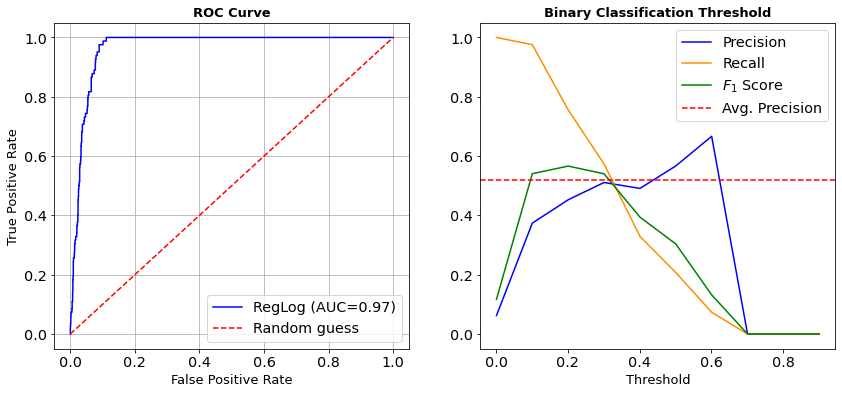

CPU times: user 667 ms, sys: 131 ms, total: 798 ms
Wall time: 721 ms


In [ ]:
%%time
f, ax = plt.subplots(1, 2, figsize=(14,6))
plot_roc_curve(y_valid_win.values.ravel(), y_prob_valid_xgb, model_name='RegLog', ax=ax[0])
plot_discrimination_threshold(y_valid_win.values.ravel(), y_prob_valid_xgb, ax=ax[1])
plt.show()

In [ ]:
y_prob_valid_xgb = xgb.predict(X_valid)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_valid_win, y_prob_valid_xgb)
print(cm)

[[1408   13]
 [  65   17]]


In [ ]:
estimator_win = XGBClassifier(n_estimators=500,max_depth=10, eta=0.4, subsample=1, colsample_bytree=1, n_jobs=-1, random_state=42)
estimator_win.fit(X_train, y_train_win.ravel())
y_pred_win = estimator_win.predict(X_valid) 


In [ ]:
cm = confusion_matrix(y_valid_win, y_pred_win)
print(cm)

[[1394   27]
 [  62   20]]


In [ ]:
y_pred_win = list(map(lambda x: 0 if x < 0.2 else 1, y_pred_win))

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cf_matrix = confusion_matrix(y_valid_win, y_pred_win)

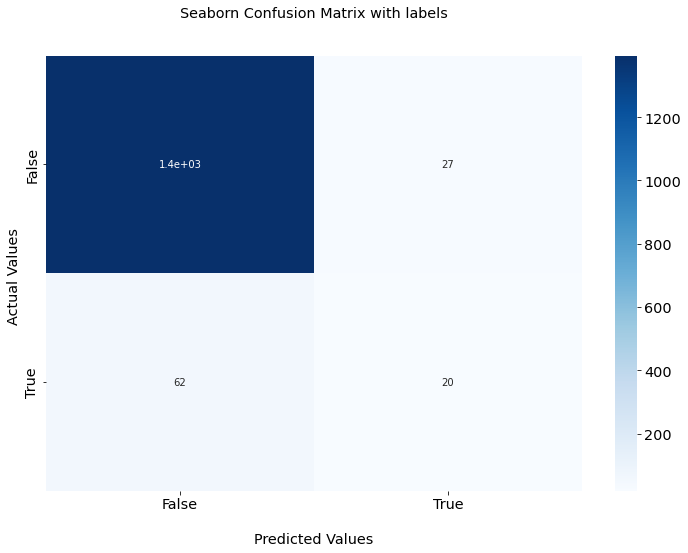

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(y_valid_win, y_pred_win)

## Découpage des prédictions par circuits pour faire un rank des probas sur le top3

In [ ]:
estimator_win = XGBClassifier(n_estimators=1000,max_depth=10, eta=0.4, subsample=1, colsample_bytree=1, n_jobs=-1, random_state=42)
estimator_win.fit(X_train_scaled, y_train_win )
y_pred_win = estimator_win.predict_proba(X_valid_scaled)


In [ ]:
estimator_win = XGBClassifier(n_estimators=500,max_depth=10, eta=0.005, subsample=0.8, colsample_bytree=0.7, n_jobs=-1, random_state=42)
estimator_win.fit(X_train_scaled, y_train_win)
y_pred_win = estimator_win.predict(X_valid_scaled) 


In [ ]:
y_pred_win_test = estimator_win.predict_proba(df_test)
len(y_pred_win_test)


# XGBOD

In [ ]:
pip install pyod

In [ ]:
from pyod.models.xgbod import XGBOD
from pyod.utils.data import evaluate_print

In [ ]:
%%time
# train XGBOD detector
clf_name = 'XGBOD'
clf = XGBOD(n_estimators= 100, max_depth=10,learning_rate=0.4, random_state=42, n_jobs=-1,verbose=1,
           colsample_bytree=1)
clf.fit(X_train, y_train_win.values.ravel())

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_valid_pred = clf.predict_proba(X_valid)
y_valid_pred_ = clf.predict(X_valid) # outlier labels (0 or 1)
y_valid_scores = clf.decision_function(X_valid)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train_win, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_valid_win, y_valid_scores)

In [ ]:
cm = confusion_matrix(y_valid_win, y_valid_pred_)
print(cm)

### Mise en forme des prédictions

In [ ]:
formule_one_test.reset_index(drop=True, inplace=True)

In [ ]:
formule_one_test = pd.merge(formule_one_test, pd.DataFrame(y_pred_win_test), left_index=True, right_index=True)

In [ ]:
formule_one_test.rename(columns = {0:'prediction_win'}, inplace = True)

In [ ]:
formule_one_test.drop(formule_one_test.columns[[69,70,73]], axis=1, inplace=True)

In [ ]:
formule_one_test['Pilote'] = formule_one_test['forename'] + ' ' + formule_one_test['surname']

In [ ]:
formule_one_test = formule_one_test[['Pilote','race_name','weather','prediction_win']]

In [ ]:
formule_one_test.to_csv('/content/drive/MyDrive/Eats up data/BDD/predictions.csv', index=False)

## Stats drivers for Viz

In [ ]:
add_nb_wins_championships = pd.DataFrame(formule_one_train.groupby(['forename','surname','year']).sum()['win']).reset_index()
add_nb_wins_championships

In [ ]:
def top3(x):
    top3 = [1,2,3]
    if x in top3:
        return 1
    else:
        return 0

In [ ]:
formule_one_train['top3'] = formule_one_train['positionOrder'].apply(top3)

In [ ]:
add_nb_top3 = pd.DataFrame(formule_one_train.groupby(['forename','surname']).sum()['top3']).reset_index()
add_nb_top3

In [ ]:
add_count_participation = formule_one_train.groupby(['forename','surname'])['year'].nunique()
add_count_participation = pd.DataFrame(add_count_participation).reset_index()
add_count_participation.rename(columns = {'year':'number_participation'}, inplace = True)


In [ ]:
add_count_participation

In [ ]:
add_nb_wins = pd.DataFrame(formule_one_train.groupby(['forename','surname']).sum()['win']).reset_index()
add_nb_wins.rename(columns = {'win':'number_wins'}, inplace = True)

In [ ]:
stats_for_viz = pd.merge(add_nb_wins_championships, add_nb_top3, how='outer', on=['forename','surname'])
stats_for_viz = pd.merge(stats_for_viz, add_count_participation, how='outer', on=['forename','surname'])
stats_for_viz = pd.merge(stats_for_viz, add_nb_wins, how='outer', on=['forename','surname'])

In [ ]:
stats_for_viz['Pilote'] = stats_for_viz['forename'] + ' ' + stats_for_viz['surname']

In [ ]:
stats_for_viz.drop(['forename','surname'], axis=1,inplace=True)

In [ ]:
stats_for_viz.to_csv('gs://bdd-eats-up-data-4/data_for_models/stats_for_viz.csv', index=False)

### Pour la DataViz get picture of drivers

def get_soup_from_url(url):
    html_classement = requests.get(url)
    soup = BeautifulSoup(html_classement.content)
    return soup

def extract_infos_drivers_pictures(url):
  soup = get_soup_from_url(url)
  drivers_add_feat = []
  #a = soup.find('a', {'class': "image"})
  row = {}
  row['driver_name'] = soup.find('title').text.split('-')[0].strip()
  row['race_name'] = soup.find('caption', {'class': "infobox-title fn"})
  row['url_picture'] = soup.find('a', {'class': "image"}).img['src']
  drivers_add_feat.append(row)
  return drivers_add_feat

In [ ]:
#liste_pilotes = drivers[(drivers.dob > '1975-01-01')].reset_index()
#DF = pd.DataFrame({})
#liste = []
#for i in liste_pilotes.url:
#    DF = DF.append(pd.DataFrame(extract_infos_drivers_pictures(i)))
#DF['url_picture'] ='http:' +DF['url_picture'].astype(str)

In [ ]:
#DF.head()

In [ ]:
#DF.to_csv('/content/drive/MyDrive/Eats up data/BDD/drivers_pic.csv', index=False)

In [ ]:
def plot_roc_curve(y_true, y_prob, model_name, ax):
    """ ROC Curve """
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)
    label_name = '{} (AUC={})'.format(model_name, round(roc_auc, 2))
    ax.plot(fpr, tpr, color='blue', label=label_name)
    ax.plot([0, 1], [0, 1], color='red', ls='--', label='Random guess')
    ax.set_title('ROC Curve', fontsize=13, weight='bold')
    ax.set_xlabel('False Positive Rate', fontsize=13)
    ax.set_ylabel('True Positive Rate', fontsize=13)
    ax.legend(loc='best')
    ax.grid(True)
    return ax

def plot_discrimination_threshold(y_true, y_prob, ax):
    """ Discrimination Threshold Plot """
    # Test Multiple Thresholds
    thresholds = np.arange(0.001, 0.999, 0.1)
    precisions, recalls, f1_scores = [], [], []
    for t in thresholds:
        y_pred_temp = (y_prob > t).astype(int)
        precision_temp = precision_score(y_true, y_pred_temp)
        recall_temp = recall_score(y_true, y_pred_temp)
        f1_score_temp = f1_score(y_true, y_pred_temp)
        precisions.append(precision_temp)
        recalls.append(recall_temp)
        f1_scores.append(f1_score_temp)

    # Plot
    ap = average_precision_score(y_true, y_prob)
    ax.plot(thresholds, precisions, color='blue', label='Precision')
    ax.plot(thresholds, recalls, color='darkorange', label='Recall')
    ax.plot(thresholds, f1_scores, color='green', label='$F_1$ Score')
    ax.axhline(ap, color='red', ls='--', label='Avg. Precision')
    ax.legend(loc='best')
    ax.set_xlabel('Threshold', fontsize=13)
    ax.set_title('Binary Classification Threshold', fontsize=13, weight='bold')
    return ax

In [ ]:
import spacy

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp(str(W.Weather[10].str.split())
for token in doc:
    print(token.text, token.pos_, token.dep_)

In [ ]:
W.Weather[10].split('[|')

In [ ]:
nlp(str(W.Weather[6].str.split()))

In [ ]:
re.split('; |, |\*|\n',a)